In [5]:
import torch
print(torch.cuda.is_available())  # True
print(torch.cuda.get_device_name(0))  # NVIDIA GeForce RTX 4060

True
NVIDIA GeForce RTX 4060 Laptop GPU


In [2]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.75, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.10, hue=0.02),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [3]:
import os, math, numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

# rutas (según tu estructura)
# lo que tenías (mal): BASE_DIR = os.path.join("002cancer")
BASE_DIR = os.path.join("..", "002_cancer")  # desde /notebooks sube a ../002_cancer
TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR   = os.path.join(BASE_DIR, "val")
TEST_DIR  = os.path.join(BASE_DIR, "test")

# parámetros que me pediste
CLASSES = 2
BATCH   = 32
ROWS = COLS = 224
INPUT_CH = 3
EPOCHS  = 15
TEST_MAX_SAMPLES = 2000
SEED    = 42

# dispositivo
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:",DEVICE)
torch.manual_seed(SEED)

Usando dispositivo: cuda


In [4]:
from torch.utils.data import Subset, DataLoader
from sklearn.model_selection import StratifiedShuffleSplit

# Comprobación de carpetas
for p in [TRAIN_DIR, TEST_DIR]:
    assert os.path.isdir(os.path.join(p, "Benign")),    f"Falta {p}/Benign"
    assert os.path.isdir(os.path.join(p, "Malignant")), f"Falta {p}/Malignant"

use_explicit_val = os.path.isdir(VAL_DIR) and all(
    os.path.isdir(os.path.join(VAL_DIR, c)) for c in ["Benign", "Malignant"]
)

from torchvision import datasets
if use_explicit_val:
    train_ds = datasets.ImageFolder(TRAIN_DIR, transform=train_transforms)
    val_ds   = datasets.ImageFolder(VAL_DIR,   transform=val_test_transforms)
else:
    full_train = datasets.ImageFolder(TRAIN_DIR, transform=train_transforms)
    y = [lbl for _, lbl in full_train.samples]
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
    train_idx, val_idx = next(sss.split(np.zeros(len(y)), y))
    train_ds = Subset(full_train, train_idx);  train_ds.dataset.transform = train_transforms
    val_ds   = Subset(full_train, val_idx);    val_ds.dataset.transform   = val_test_transforms

test_ds  = datasets.ImageFolder(TEST_DIR, transform=val_test_transforms)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PIN = (DEVICE.type == "cuda")
NUM_WORKERS = 0 if os.name == "nt" else 4

def seed_worker(worker_id):
    import numpy as _np, random as _rand
    _np.random.seed(SEED + worker_id); _rand.seed(SEED + worker_id)

g = torch.Generator(); g.manual_seed(SEED)

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=PIN,
                          worker_init_fn=seed_worker, generator=g)
val_loader   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=PIN,
                          worker_init_fn=seed_worker)
test_loader  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=PIN,
                          worker_init_fn=seed_worker)

# Mapeo de clases
if use_explicit_val:
    class_to_idx = datasets.ImageFolder(TRAIN_DIR).class_to_idx
else:
    class_to_idx = train_ds.dataset.class_to_idx if hasattr(train_ds, "dataset") else datasets.ImageFolder(TRAIN_DIR).class_to_idx
idx_to_class = {v:k for k,v in class_to_idx.items()}
print("Clases:", class_to_idx)
print(f"Train={len(train_ds)} | Val={len(val_ds)} | Test={len(test_ds)}")

Clases: {'Benign': 0, 'Malignant': 1}
Train=9503 | Val=2376 | Test=2000


In [5]:
from collections import Counter
import torch
from torch.utils.data import WeightedRandomSampler

def get_labels_from_subset(subset):
    if hasattr(subset, 'indices'):  # Subset
        targets = [subset.dataset.samples[i][1] for i in subset.indices]
    else:  # ImageFolder
        targets = [s[1] for s in subset.samples]
    return targets

train_labels = get_labels_from_subset(train_ds)
class_counts = Counter(train_labels)
total = sum(class_counts.values())
class_weight = {c: total / (len(class_counts)*n) for c, n in class_counts.items()}
sample_weights = [class_weight[y] for y in train_labels]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_ds, batch_size=BATCH, sampler=sampler,
                          num_workers=NUM_WORKERS, pin_memory=PIN,
                          worker_init_fn=seed_worker, generator=g)

In [14]:
# ===== Celda 6 (StableCNN-Lite: más rápido y ligero) =====
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

def _gn_groups(ch):
    for g in [16,8,4,2,1]:
        if ch % g == 0: return g
    return 1

class ConvGNSiLU(nn.Sequential):
    def __init__(self, in_ch, out_ch, k=3, s=1, p=1, bias=False):
        super().__init__(
            nn.Conv2d(in_ch, out_ch, kernel_size=k, stride=s, padding=p, bias=bias),
            nn.GroupNorm(_gn_groups(out_ch), out_ch),
            nn.SiLU(inplace=True),
        )

class ResidualLite(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1, p_drop2d=0.0):
        super().__init__()
        self.conv1 = ConvGNSiLU(in_ch, out_ch, s=stride)
        self.conv2 = ConvGNSiLU(out_ch, out_ch)
        self.drop = nn.Dropout2d(p_drop2d)
        self.proj = None
        if in_ch != out_ch or stride != 1:
            self.proj = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=stride, bias=False),
                nn.GroupNorm(_gn_groups(out_ch), out_ch)
            )
    def forward(self, x):
        y = self.conv1(x)
        y = self.conv2(y)
        if self.proj is not None:
            x = self.proj(x)
        y = self.drop(y)
        return F.silu(x + y)

class ConcatPool2d(nn.Module):
    def __init__(self):
        super().__init__()
        self.avg = nn.AdaptiveAvgPool2d(1)
        self.max = nn.AdaptiveMaxPool2d(1)
    def forward(self, x):
        return torch.cat([self.avg(x), self.max(x)], dim=1)

class StableCNN(nn.Module):
    def __init__(self, in_ch=3, num_classes=2):
        super().__init__()
        # Menos canales en cada bloque → mucho más rápido
        self.stem = nn.Sequential(
            ConvGNSiLU(in_ch, 32),
            ConvGNSiLU(32, 64),
        )
        self.stage1 = nn.Sequential(
            ResidualLite(64, 64, stride=1, p_drop2d=0.05),
            ResidualLite(64, 64, stride=2, p_drop2d=0.05),  # 224→112
        )
        self.stage2 = nn.Sequential(
            ResidualLite(64, 128, stride=1, p_drop2d=0.05),
            ResidualLite(128,128, stride=2, p_drop2d=0.05),  # 112→56
        )
        self.stage3 = nn.Sequential(
            ResidualLite(128,192, stride=1, p_drop2d=0.05),
            ResidualLite(192,192, stride=2, p_drop2d=0.05),  # 56→28
        )
        self.stage4 = nn.Sequential(
            ResidualLite(192,256, stride=2, p_drop2d=0.05),  # 28→14
        )
        self.pool = ConcatPool2d()
        feat_ch = 256 * 2
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(feat_ch, 128),
            nn.SiLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
        self._init()

    def _init(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, a=math.sqrt(5))
                if m.bias is not None: nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.stem(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.pool(x)
        x = self.classifier(x)
        return x

model = StableCNN(in_ch=INPUT_CH, num_classes=CLASSES).to(DEVICE)
print(model)

StableCNN(
  (stem): Sequential(
    (0): ConvGNSiLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): GroupNorm(16, 32, eps=1e-05, affine=True)
      (2): SiLU(inplace=True)
    )
    (1): ConvGNSiLU(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): GroupNorm(16, 64, eps=1e-05, affine=True)
      (2): SiLU(inplace=True)
    )
  )
  (stage1): Sequential(
    (0): ResidualLite(
      (conv1): ConvGNSiLU(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): GroupNorm(16, 64, eps=1e-05, affine=True)
        (2): SiLU(inplace=True)
      )
      (conv2): ConvGNSiLU(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): GroupNorm(16, 64, eps=1e-05, affine=True)
        (2): SiLU(inplace=True)
      )
      (drop): Dropout2d(p=0.05, inplace=False)
    )
    (1): ResidualLite(
      (conv1): Co

In [16]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.nn.utils import clip_grad_norm_

# Label Smoothing (reduce picos/varianza)
class LabelSmoothingCE(nn.Module):
    def __init__(self, eps=0.05):
        super().__init__()
        self.eps = eps
        self.log_softmax = nn.LogSoftmax(dim=1)
    def forward(self, logits, target):
        n_classes = logits.size(1)
        logprobs  = self.log_softmax(logits)
        nll = nn.functional.nll_loss(logprobs, target, reduction='mean')
        smooth = -logprobs.mean(dim=1).mean()
        return (1 - self.eps) * nll + self.eps * smooth

criterion = LabelSmoothingCE(eps=0.05)

# LR más bajo + weight decay más fuerte
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=5e-4)

# Warmup + Cosine (más suave que ReduceLROnPlateau)
WARMUP_EPOCHS = 3
scheduler_cos = CosineAnnealingLR(optimizer, T_max=max(1, EPOCHS - WARMUP_EPOCHS), eta_min=1e-6)

USE_AMP = (DEVICE.type == "cuda")
scaler  = torch.cuda.amp.GradScaler(enabled=USE_AMP)

def scheduler_step(epoch):
    if epoch < WARMUP_EPOCHS:
        for pg in optimizer.param_groups:
            pg['lr'] = 3e-4 * (epoch + 1) / WARMUP_EPOCHS
    else:
        scheduler_cos.step()

def run_epoch(loader, train_mode=True):
    model.train() if train_mode else model.eval()
    total, correct, running = 0, 0, 0.0

    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        if train_mode:
            optimizer.zero_grad(set_to_none=True)

        if USE_AMP:
            with torch.cuda.amp.autocast():
                logits = model(xb)
                loss   = criterion(logits, yb)
        else:
            logits = model(xb); loss = criterion(logits, yb)

        if train_mode:
            if USE_AMP:
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                clip_grad_norm_(model.parameters(), 1.0)
                scaler.step(optimizer); scaler.update()
            else:
                loss.backward()
                clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()

        running += loss.item() * xb.size(0)
        pred = logits.argmax(1)
        total += yb.size(0)
        correct += (pred == yb).sum().item()

    return running/total, correct/total

C:\Users\1cnac\AppData\Local\Temp\ipykernel_26464\1745331884.py:29: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler  = torch.cuda.amp.GradScaler(enabled=USE_AMP)


In [3]:
# Entrenamiento completo (sin early stopping) guardando histórico
import numpy as np, os

history = {
    "EPOCHS": [],
    "train_loss": [], "val_loss": [],
    "train_acc":  [], "val_acc":  [],
}

# Si ya tienes class_to_idx, omite esto.
try:
    class_to_idx
except NameError:
    from torchvision import datasets
    class_to_idx = datasets.ImageFolder(TRAIN_DIR).class_to_idx

idx_to_class = {v:k for k,v in class_to_idx.items()}
malignant_index = class_to_idx.get("Malignant", 1)  # por si la carpeta se llama distinto, ajusta aquí
print("class_to_idx:", class_to_idx, "| malignant_index:", malignant_index)

NameError: name 'TRAIN_DIR' is not defined

In [18]:
@torch.no_grad()
def evaluate_with_fn(loader):
    model.eval()
    total, correct, running = 0, 0, 0.0
    fn_total = 0
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)

        if USE_AMP:
            with torch.cuda.amp.autocast():
                logits = model(xb)
                loss   = criterion(logits, yb)
        else:
            logits = model(xb)
            loss   = criterion(logits, yb)

        running += loss.item() * xb.size(0)
        preds = logits.argmax(1)

        total += yb.size(0)
        correct += (preds == yb).sum().item()

        # FN = verdaderos Malignant predichos como NO-Malignant
        fn_total += ((preds != malignant_index) & (yb == malignant_index)).sum().item()

    return running/total, correct/total, fn_total

In [19]:
# Celda 10 — no-op para mantener el bucle estable con StableCNN
def maybe_unfreeze(epoch):
    return  # (equivalente a 'pass')

In [20]:
best_val_loss = float("inf")
best_val_fn   = float("inf")
best_path     = "stablecnn_minFN9.pt"
# Si NO quieres early stopping, pon patience=None
patience      = None
epochs_no_improve = 0

for epoch in range(1, EPOCHS+1):
    maybe_unfreeze(epoch)
    tr_loss, tr_acc = run_epoch(train_loader, train_mode=True)
    va_loss, va_acc, va_fn = evaluate_with_fn(val_loader)

    # scheduler suave
    scheduler_step(epoch)

    # histórico
    history["EPOCHS"].append(epoch)
    history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss);   history["val_acc"].append(va_acc)

    print(f"[{epoch:02d}/{EPOCHS}] "
          f"train_loss={tr_loss:.4f} acc={tr_acc:.3f} | "
          f"val_loss={va_loss:.4f} acc={va_acc:.3f} | "
          f"val_FN={va_fn} | "
          f"lr={optimizer.param_groups[0]['lr']:.6f}", flush=True)

    # guardar mejor por FN (desempata por menor val_loss)
    improved = (va_fn < best_val_fn) or ((va_fn == best_val_fn) and (va_loss < best_val_loss - 1e-4))
    if improved:
        best_val_fn = va_fn; best_val_loss = va_loss; epochs_no_improve = 0
        torch.save({
            "model_state": model.state_dict(),
            "class_to_idx": class_to_idx,
            "malignant_index": malignant_index,
            "best_val_fn": best_val_fn,
            "best_val_loss": best_val_loss,
            "epoch": epoch
        }, best_path)
        print(f"✔️ Guardado mejor modelo (min FN): FN={best_val_fn}, loss={best_val_loss:.4f} -> {best_path}", flush=True)
    else:
        if patience is not None:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping (sin mejora en FN).", flush=True)
                break

C:\Users\1cnac\AppData\Local\Temp\ipykernel_26464\1745331884.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\1cnac\AppData\Local\Temp\ipykernel_26464\316291866.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[01/15] train_loss=0.4784 acc=0.800 | val_loss=0.4463 acc=0.797 | val_FN=51 | lr=0.000200
✔️ Guardado mejor modelo (min FN): FN=51, loss=0.4463 -> stablecnn_minFN9.pt
[02/15] train_loss=0.3959 acc=0.852 | val_loss=0.3647 acc=0.867 | val_FN=118 | lr=0.000300
[03/15] train_loss=0.3779 acc=0.863 | val_loss=0.3862 acc=0.865 | val_FN=115 | lr=0.000295
[04/15] train_loss=0.3488 acc=0.881 | val_loss=0.3633 acc=0.869 | val_FN=97 | lr=0.000280
[05/15] train_loss=0.3481 acc=0.878 | val_loss=0.3467 acc=0.880 | val_FN=102 | lr=0.000256
[06/15] train_loss=0.3342 acc=0.884 | val_loss=0.3416 acc=0.879 | val_FN=121 | lr=0.000225
[07/15] train_loss=0.3208 acc=0.894 | val_loss=0.3343 acc=0.886 | val_FN=95 | lr=0.000189
[08/15] train_loss=0.3021 acc=0.905 | val_loss=0.3291 acc=0.889 | val_FN=118 | lr=0.000150
[09/15] train_loss=0.2978 acc=0.910 | val_loss=0.3392 acc=0.888 | val_FN=113 | lr=0.000112
[10/15] train_loss=0.2853 acc=0.915 | val_loss=0.3254 acc=0.896 | val_FN=122 | lr=0.000076
[11/15] train_lo

In [21]:
ckpt = torch.load("stablecnn_minFN9.pt", map_location=DEVICE)
model.load_state_dict(ckpt["model_state"])
class_to_idx = ckpt["class_to_idx"]
malignant_index = ckpt.get("malignant_index", class_to_idx.get("Malignant", 1))
idx_to_class = {v:k for k,v in class_to_idx.items()}
print(f"Mejor modelo cargado | FN={ckpt.get('best_val_fn')} loss={ckpt.get('best_val_loss')}", flush=True)

Mejor modelo cargado | FN=51 loss=0.44627559034511294


C:\Users\1cnac\AppData\Local\Temp\ipykernel_26464\3760334594.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("stablecnn_minFN9.pt", map_location=DEVICE

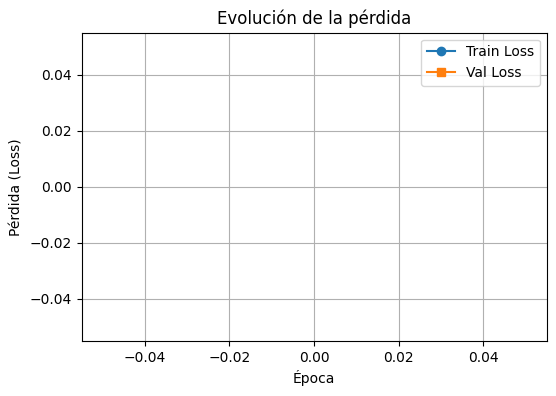

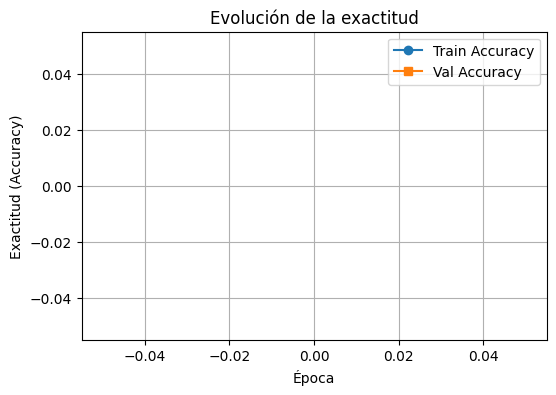

NameError: name 'val_loader' is not defined

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# ====== 1. LOSS ======
plt.figure(figsize=(6,4))
plt.plot(history["EPOCHS"], history["train_loss"], label="Train Loss", marker='o')
plt.plot(history["EPOCHS"], history["val_loss"], label="Val Loss", marker='s')
plt.xlabel("Época")
plt.ylabel("Pérdida (Loss)")
plt.title("Evolución de la pérdida")
plt.legend()
plt.grid(True)
plt.show()

# ====== 2. ACCURACY ======
plt.figure(figsize=(6,4))
plt.plot(history["EPOCHS"], history["train_acc"], label="Train Accuracy", marker='o')
plt.plot(history["EPOCHS"], history["val_acc"], label="Val Accuracy", marker='s')
plt.xlabel("Época")
plt.ylabel("Exactitud (Accuracy)")
plt.title("Evolución de la exactitud")
plt.legend()
plt.grid(True)
plt.show()

# ====== 3. MATRIZ DE CONFUSIÓN (validación) ======
@torch.no_grad()
def predict_with_threshold(loader, thr=0.5):
    model.eval()
    probs, labels = [], []
    for xb, yb in loader:
        xb = xb.to(DEVICE)
        with torch.cuda.amp.autocast(enabled=USE_AMP):
            logits = model(xb)
            p = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()
        probs.append(p)
        labels.append(yb.numpy())
    probs = np.concatenate(probs)
    labels = np.concatenate(labels)
    y_true = (labels == malignant_index).astype(int)
    y_pred = (probs >= thr).astype(int)
    return y_true, y_pred

# Usa tu umbral óptimo si lo calculaste; si no, usa 0.5
try:
    threshold = thr
except NameError:
    threshold = 0.5

y_true, y_pred = predict_with_threshold(val_loader, thr=threshold)

cm = confusion_matrix(y_true, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Malignant"])
disp.plot(cmap="Blues", values_format="d")
plt.title(f"Matriz de confusión (umbral={threshold:.2f})")
plt.show()

tn, fp, fn, tp = cm.ravel()
print(f"TN={tn}, FP={fp}, FN={fn}, TP={tp}")
acc = (tp + tn) / (tn + fp + fn + tp)
print(f"Accuracy global (val) = {acc:.4f}")


In [ ]:
import numpy as np
from sklearn.metrics import f1_score

@torch.no_grad()
def get_probs_and_labels(loader):
    model.eval()
    probs, labels = [], []
    for xb, yb in loader:
        xb = xb.to(DEVICE)
        with torch.cuda.amp.autocast(enabled=USE_AMP):
            logits = model(xb)
            p = torch.softmax(logits, dim=1)[:,1].cpu().numpy()  # prob de Malignant
        probs.append(p); labels.append(yb.numpy())
    return np.concatenate(probs), np.concatenate(labels)

val_p, val_y = get_probs_and_labels(val_loader)

# buscamos el umbral que maximiza F2 (recall priorizado) o el que minimiza FN
def best_threshold_for_f2(p, y):
    best_t, best_f2 = 0.5, -1
    for t in np.linspace(0.1, 0.9, 81):
        yhat = (p >= t).astype(int)
        f2 = f1_score(y, yhat, beta=2)  # F2
        if f2 > best_f2:
            best_f2, best_t = f2, t
    return best_t, best_f2

thr, f2 = best_threshold_for_f2(val_p, val_y)
print(f"Umbral óptimo (F2): {thr:.3f} | F2={f2:.3f}")

C:\Users\1cnac\AppData\Local\Temp\ipykernel_26464\4177531049.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):


TypeError: got an unexpected keyword argument 'beta'

: 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
def smooth(x, k=3):
    import numpy as np
    if len(x) < k: return np.array(x, float)
    x = np.array(x, float)
    return np.convolve(x, np.ones(k)/k, mode="valid")

k = 3
if len(history["EPOCHS"]) >= k:
    e2 = history["EPOCHS"][k-1:]
    plt.figure(figsize=(6,4))
    plt.plot(e2, smooth(history["train_loss"],k), label="Train loss (sm)")
    plt.plot(e2, smooth(history["val_loss"],k), label="Val loss (sm)")
    plt.xlabel("Época"); plt.ylabel("Pérdida"); plt.title("Loss suavizada")
    plt.legend(); plt.grid(True); plt.show()

    plt.figure(figsize=(6,4))
    plt.plot(e2, smooth(history["train_acc"],k), label="Train acc (sm)")
    plt.plot(e2, smooth(history["val_acc"],k), label="Val acc (sm)")
    plt.xlabel("Época"); plt.ylabel("Exactitud"); plt.title("Accuracy suavizada")
    plt.legend(); plt.grid(True); plt.show()

NameError: name 'history' is not defined

In [ ]:
# --- TTA sencillo: predicción + flip horizontal ---
def predict_with_tta(xb):
    with torch.cuda.amp.autocast(enabled=USE_AMP):
        logits1 = model(xb)
        p1 = torch.softmax(logits1, dim=1)[:,1]
        logits2 = model(torch.flip(xb, dims=[3]))  # flip horizontal
        p2 = torch.softmax(logits2, dim=1)[:,1]
    return ((p1 + p2)/2)

model.eval()
all_probs, all_labels = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(DEVICE)
        p = predict_with_tta(xb)  # o usa get_probs_and_labels sin TTA si prefieres
        all_probs.append(p.cpu())
        all_labels.append(yb)

all_probs  = torch.cat(all_probs).numpy()
all_labels = torch.cat(all_labels).numpy()

all_preds = (all_probs >= thr).astype(int)  # <--- UMBRAL ÓPTIMO

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, average_precision_score
test_acc = (all_preds == all_labels).mean()
print(f"Test accuracy: {test_acc:.4f}")
print(f"ROC-AUC: {roc_auc_score(all_labels, all_probs):.4f} | AP (PR-AUC): {average_precision_score(all_labels, all_probs):.4f}")
print(classification_report(all_labels, all_preds, target_names=[idx_to_class[0], idx_to_class[1]]))

cm = confusion_matrix(all_labels, all_preds, labels=[0,1])
# ... tu mismo código para plotear la matriz (sin cambios) ...
